In [2]:
## import os
import shutil
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# 資料增強與標準化
transform = transforms.Compose([
    transforms.Resize(256),  # 首先將圖像大小調整為 256x256
    transforms.CenterCrop(224),  # 然後將圖像中心裁剪為 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_train_dir = '../train'
base_val_dir = '../val'
base_test_dir = '../test'

# 創建資料集
train_dataset = datasets.ImageFolder(base_train_dir, transform=transform)
val_dataset = datasets.ImageFolder(base_val_dir, transform=transform)
test_dataset = datasets.ImageFolder(base_test_dir, transform=transform)

# 創建資料加載器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
from tqdm import tqdm

# 訓練函數
def train(epoch, epochs, model, train_loader, optimizer, loss_function, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_bar = tqdm(train_loader, file=sys.stdout)
    
    for step, data in enumerate(train_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # 確保數據在正確的設備上
        optimizer.zero_grad()
        logits = model(images)  # 模型輸出
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 計算準確率
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
    running_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return running_loss, accuracy

In [4]:
# 驗證函數
def validate(epoch, epochs, model, validate_loader, loss_function, device):
    model.eval()
    acc = 0.0
    val_loss = 0.0
    val_num = len(validate_loader.dataset)
    
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            outputs = model(val_images)
            loss = loss_function(outputs, val_labels)
            val_loss += loss.item() * val_images.size(0)

            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels).sum().item()

            val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)
    
    val_loss /= val_num
    val_accurate = 100. *acc / val_num
    return val_loss, val_accurate

In [22]:
from resnet import resnet34 
# 設定設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {} device.".format(device))

# 定義 ResNet-34 模型（不使用預訓練權重）
model = resnet34(num_classes=50, include_top=True)
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

using cuda device.


In [23]:
import time
import sys
import tqdm as notebook_tqdm

# 訓練和驗證模型
num_epochs = 10
best_acc = 0.0
save_path = 'best_resnet34.pth'
t_l, t_a = [], []
v_l, v_a = [], []
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(epoch, num_epochs, model, train_loader, optimizer, criterion, device)
    val_loss, val_accurate = validate(epoch, num_epochs, model, val_loader, criterion, device)
    t_l.append(train_loss)
    t_a.append(train_accuracy)
    v_l.append(val_loss)
    v_a.append(val_accurate)
    
    print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
            (epoch + 1, train_loss, train_accuracy))
    print('[epoch %d] val_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, val_loss, val_accurate))
    
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    print(f'Training_Time: {end_time - start_time:.2f} seconds')
    
print('訓練完成')

valid epoch[1/10]: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]
[epoch 1] train_loss: 3.207  train_accuracy: 14.659
[epoch 1] val_loss: 2.812  val_accuracy: 22.000
Training_Time: 160.43 seconds
valid epoch[2/10]: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
[epoch 2] train_loss: 2.541  train_accuracy: 28.163
[epoch 2] val_loss: 2.522  val_accuracy: 30.667
Training_Time: 165.85 seconds
valid epoch[3/10]: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]
[epoch 3] train_loss: 2.078  train_accuracy: 39.019
[epoch 3] val_loss: 2.092  val_accuracy: 37.556
Training_Time: 162.48 seconds
valid epoch[4/10]: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]
[epoch 4] train_loss: 1.710  train_accuracy: 48.578
[epoch 4] val_loss: 1.798  val_accuracy: 43.778
Training_Time: 162.31 seconds
valid epoch[5/10]: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]
[epoch 5] train_loss: 1.457  train_accuracy: 55.376
[epoch 5] val_loss: 1.644  val_accuracy: 49.778
Training_Time: 167.03 seconds
valid epoch[6/10]: 100%|█

In [24]:
# 測試模型
model.load_state_dict(torch.load('best_resnet34.pth'))
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.6289


In [18]:
def save_metrics_to_file(t_l, t_a, v_l, v_a, filename='metrics.txt'):
    with open(filename, 'w') as file:
        file.write("Train Loss:\n")
        for item in t_l:
            file.write(f"{item}\n")
        
        file.write("Train Accuracy:\n")
        for item in t_a:
            file.write(f"{item}\n")
        
        file.write("Validation Loss:\n")
        for item in v_l:
            file.write(f"{item}\n")
        
        file.write("Validation Accuracy:\n")
        for item in v_a:
            file.write(f"{item}\n")

In [26]:
# 假設 t_l, t_a, v_l, v_a 已經被填充
filename = 'resnet34.txt'
save_metrics_to_file(t_l, t_a, v_l, v_a, filename)

# import revised-alexnet

In [10]:
from revised_alexnet import AlexNet
# 設定設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {} device.".format(device))

# 定義 revised_alexnet 模型（不使用預訓練權重）
model = AlexNet(num_classes=50)
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

using cuda device.


In [17]:
import time
import sys
import tqdm as notebook_tqdm

# 訓練和驗證模型
num_epochs = 10
best_acc = 0.0
save_path = 'best_re_alexnet.pth'
t_l, t_a = [], []
v_l, v_a = [], []
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(epoch, num_epochs, model, train_loader, optimizer, criterion, device)
    val_loss, val_accurate = validate(epoch, num_epochs, model, val_loader, criterion, device)
    t_l.append(train_loss)
    t_a.append(train_accuracy)
    v_l.append(val_loss)
    v_a.append(val_accurate)
    
    print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
            (epoch + 1, train_loss, train_accuracy))
    print('[epoch %d] val_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, val_loss, val_accurate))
    
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    print(f'Training_Time: {end_time - start_time:.2f} seconds')
    
print('訓練完成')

valid epoch[1/10]: 100%|██████████| 15/15 [00:00<00:00, 23.67it/s]
[epoch 1] train_loss: 3.911  train_accuracy: 1.832
[epoch 1] val_loss: 3.913  val_accuracy: 2.000
Training_Time: 109.73 seconds
valid epoch[2/10]: 100%|██████████| 15/15 [00:00<00:00, 24.59it/s]
[epoch 2] train_loss: 3.910  train_accuracy: 1.931
[epoch 2] val_loss: 3.914  val_accuracy: 2.000
Training_Time: 108.18 seconds
valid epoch[3/10]: 100%|██████████| 15/15 [00:00<00:00, 25.13it/s]
[epoch 3] train_loss: 3.910  train_accuracy: 1.911
[epoch 3] val_loss: 3.915  val_accuracy: 2.000
Training_Time: 104.81 seconds
valid epoch[4/10]: 100%|██████████| 15/15 [00:00<00:00, 25.60it/s]
[epoch 4] train_loss: 3.910  train_accuracy: 1.843
[epoch 4] val_loss: 3.915  val_accuracy: 2.000
Training_Time: 107.43 seconds
valid epoch[5/10]: 100%|██████████| 15/15 [00:00<00:00, 25.09it/s]
[epoch 5] train_loss: 3.910  train_accuracy: 1.893
[epoch 5] val_loss: 3.915  val_accuracy: 2.000
Training_Time: 106.25 seconds
valid epoch[6/10]: 100%|█

In [ ]:
# 測試模型
model.load_state_dict(torch.load('best_re_alexnet.pth'))
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Acc: {test_acc:.4f}')

In [18]:
# 假設 t_l, t_a, v_l, v_a 已經被填充
filename = 're_alexnet.txt'
save_metrics_to_file(t_l, t_a, v_l, v_a, filename)

# import revised ResNet

In [6]:
from revised_res import revised_resnet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {} device.".format(device))

# 定義 revised_RDN 模型（不使用預訓練權重）
model = revised_resnet()
model = model.to(device) 

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

using cuda device.


In [7]:
import time
import sys
import tqdm as notebook_tqdm

# 訓練和驗證模型
num_epochs = 10
best_acc = 0.0
save_path = 'best_revised_ResNet.pth'
t_l, t_a = [], []
v_l, v_a = [], []
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(epoch, num_epochs, model, train_loader, optimizer, criterion, device)
    val_loss, val_accurate = validate(epoch, num_epochs, model, val_loader, criterion, device)
    t_l.append(train_loss)
    t_a.append(train_accuracy)
    v_l.append(val_loss)
    v_a.append(val_accurate)
    
    print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
            (epoch + 1, train_loss, train_accuracy))
    print('[epoch %d] val_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, val_loss, val_accurate))
    
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    print(f'Training_Time: {end_time - start_time:.2f} seconds')
    
print('訓練完成')

valid epoch[1/10]: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]
[epoch 1] train_loss: 3.422  train_accuracy: 11.270
[epoch 1] val_loss: 3.254  val_accuracy: 16.444
Training_Time: 198.38 seconds
valid epoch[2/10]: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]
[epoch 2] train_loss: 2.964  train_accuracy: 18.969
[epoch 2] val_loss: 3.262  val_accuracy: 18.000
Training_Time: 166.43 seconds
valid epoch[3/10]: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]
[epoch 3] train_loss: 2.667  train_accuracy: 25.075
[epoch 3] val_loss: 2.624  val_accuracy: 29.111
Training_Time: 166.07 seconds
valid epoch[4/10]: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]
[epoch 4] train_loss: 2.457  train_accuracy: 29.655
[epoch 4] val_loss: 2.517  val_accuracy: 28.667
Training_Time: 167.09 seconds
valid epoch[5/10]: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]
[epoch 5] train_loss: 2.270  train_accuracy: 33.960
[epoch 5] val_loss: 2.235  val_accuracy: 34.000
Training_Time: 168.24 seconds
valid epoch[6/10]: 100%|█

In [8]:
# 測試模型
model.load_state_dict(torch.load('best_revised_ResNet.pth'))
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.4822


# import CustomMobileNetV3

In [14]:
from re_mobile import CustomMobileNetV3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {} device.".format(device))

# 定義 revised_RDN 模型（不使用預訓練權重）
model = CustomMobileNetV3()
model = model.to(device) 

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

using cuda device.


In [15]:
import time
import sys
import tqdm as notebook_tqdm

# 訓練和驗證模型
num_epochs = 10
best_acc = 0.0
save_path = 'best_CustomMobileNetV3.pth'
t_l, t_a = [], []
v_l, v_a = [], []
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(epoch, num_epochs, model, train_loader, optimizer, criterion, device)
    val_loss, val_accurate = validate(epoch, num_epochs, model, val_loader, criterion, device)
    t_l.append(train_loss)
    t_a.append(train_accuracy)
    v_l.append(val_loss)
    v_a.append(val_accurate)
    
    print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
            (epoch + 1, train_loss, train_accuracy))
    print('[epoch %d] val_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, val_loss, val_accurate))
    
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    print(f'Training_Time: {end_time - start_time:.2f} seconds')
    
print('訓練完成')

valid epoch[1/10]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]
[epoch 1] train_loss: 3.335  train_accuracy: 13.143
[epoch 1] val_loss: 3.143  val_accuracy: 16.444
Training_Time: 103.80 seconds
valid epoch[2/10]: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s]
[epoch 2] train_loss: 3.055  train_accuracy: 18.299
[epoch 2] val_loss: 2.977  val_accuracy: 18.444
Training_Time: 104.55 seconds
valid epoch[3/10]: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]
[epoch 3] train_loss: 2.926  train_accuracy: 20.771
[epoch 3] val_loss: 2.909  val_accuracy: 18.889
Training_Time: 105.45 seconds
valid epoch[4/10]: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]
[epoch 4] train_loss: 2.844  train_accuracy: 22.389
[epoch 4] val_loss: 2.831  val_accuracy: 20.000
Training_Time: 105.98 seconds
valid epoch[5/10]: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s]
[epoch 5] train_loss: 2.775  train_accuracy: 23.934
[epoch 5] val_loss: 2.822  val_accuracy: 18.667
Training_Time: 105.74 seconds
valid epoch[6/10]: 100%|█

In [16]:
# 測試模型
model.load_state_dict(torch.load('best_CustomMobileNetV3.pth'))
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.2911


In [19]:
# 假設 t_l, t_a, v_l, v_a 已經被填充
filename = 'CustomMobileNetV3.txt'
save_metrics_to_file(t_l, t_a, v_l, v_a, filename)

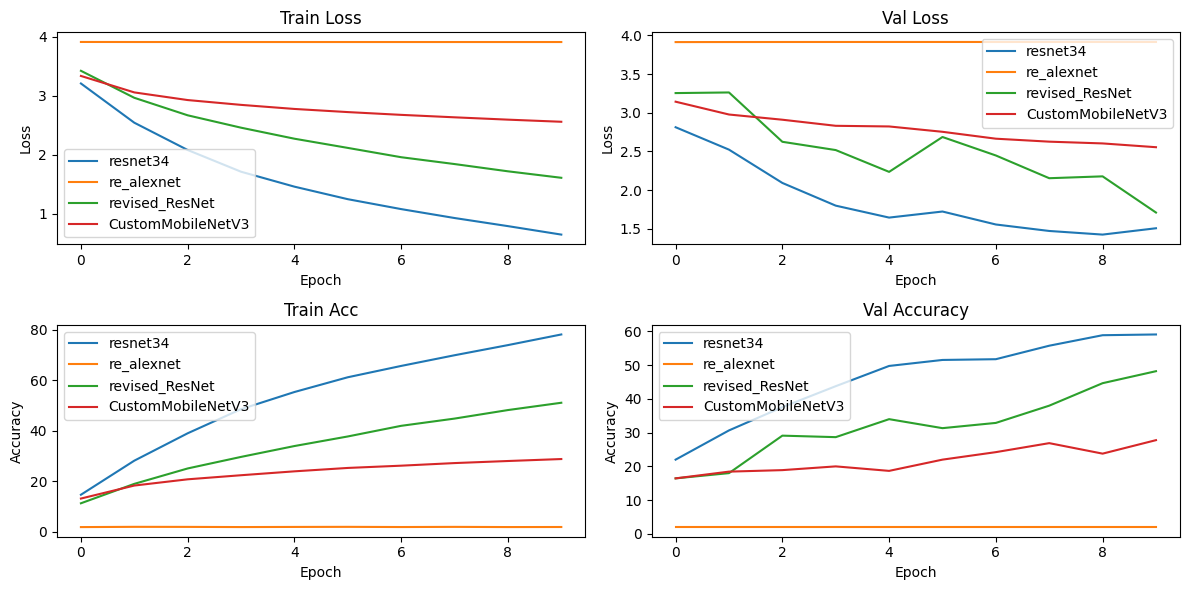

In [22]:
import matplotlib.pyplot as plt

# 讀取txt文件並提取數據
def read_data(file_path):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
                if 0 < i < 11:
                    train_losses.append(float(lines[i].strip()))
                    i += 1

                elif 11 < i < 22:
                    train_accuracies.append(float(lines[i].strip()))
                    i += 1
                    
                elif 22 < i < 33:
                    val_losses.append(float(lines[i].strip()))
                    i += 1
                    
                elif 33 < i < 44:
                    val_accuracies.append(float(lines[i].strip()))
                    i += 1
                else:
                    i += 1
    return train_losses, train_accuracies, val_losses, val_accuracies

# 讀取訓練和驗證數據
train_losses_1, train_accuracies_1, val_losses_1, val_accuracies_1 = read_data('resnet34.txt')
train_losses_2, train_accuracies_2, val_losses_2, val_accuracies_2 = read_data('re_alexnet.txt')
train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 = read_data('revised_ResNet.txt')
train_losses_4, train_accuracies_4, val_losses_4, val_accuracies_4 = read_data('CustomMobileNetV3.txt')

x = []
for i in range(10):
    x.append(i)

# 繪製訓練和驗證損失
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(x, train_losses_1, label='resnet34')
plt.plot(x, train_losses_2, label='re_alexnet')
plt.plot(x, train_losses_3, label='revised_ResNet')
plt.plot(x, train_losses_4, label='CustomMobileNetV3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

# 繪製訓練和驗證準確度
plt.subplot(2, 2, 2)
plt.plot(x, val_losses_1, label='resnet34')
plt.plot(x, val_losses_2, label='re_alexnet')
plt.plot(x, val_losses_3, label='revised_ResNet')
plt.plot(x, val_losses_4, label='CustomMobileNetV3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_accuracies_1, label='resnet34')
plt.plot(train_accuracies_2, label='re_alexnet')
plt.plot(train_accuracies_3, label='revised_ResNet')
plt.plot(train_accuracies_4, label='CustomMobileNetV3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Acc')
plt.legend()

# 繪製訓練和驗證準確度
plt.subplot(2, 2, 4)
plt.plot(val_accuracies_1, label='resnet34')
plt.plot(val_accuracies_2, label='re_alexnet')
plt.plot(val_accuracies_3, label='revised_ResNet')
plt.plot(val_accuracies_4, label='CustomMobileNetV3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy')
plt.legend()

plt.tight_layout()
plt.show()